## Topics



### 1. Problem Definition  
### 2. Exploratory Data Analysis (EDA)  
### 3. Text Preprocessing
### 4. Model Selection  
### 5. Hyperparameter Tuning  




-----



### **1. Problem Definition**

- **1.1. Identify the Problem**  
    The goal is to develop a machine learning model capable of distinguishing between text written by humans and text generated by AI models (e.g., ChatGPT, Gemini). This has applications in academic integrity, misinformation detection, content moderation, and authorship verification.

- **1.2. Define the Machine Learning Objective**  
    This is a **binary classification** task:
    - **Class 0**: Human-written text  
    - **Class 1**: AI-generated text  

- **1.3. Specify the Output**  
    The model should output either a class label (0 or 1) or a probability score indicating the likelihood that the input text is AI-generated.





--------

## Exploratory Data Analysis (EDA)  

Main tools

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from collections import Counter
import string
import re
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


import optuna


In [2]:
df = pd.read_csv('./data/AI_Human.csv')

In [3]:
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [6]:
df.describe()

,generated
count,487235.000000
mean,0.372383
std,0.483440
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Number of AI generated texts vs human text

In [7]:
df['generated'].value_counts(normalize=True)


generated
0.0    0.627617
1.0    0.372383
Name: proportion, dtype: float64

Now, let's check the length of texts

In [8]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
df['text_length'].describe()

count    487235.000000
mean        393.096214
std         168.593328
min           0.000000
25%         278.000000
50%         363.000000
75%         471.000000
max        1668.000000
Name: text_length, dtype: float64

In [9]:
df['text_length'].head()

0    584
1    462
2    744
3    686
4    871
Name: text_length, dtype: int64

Plot distribution of text lengths by label


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


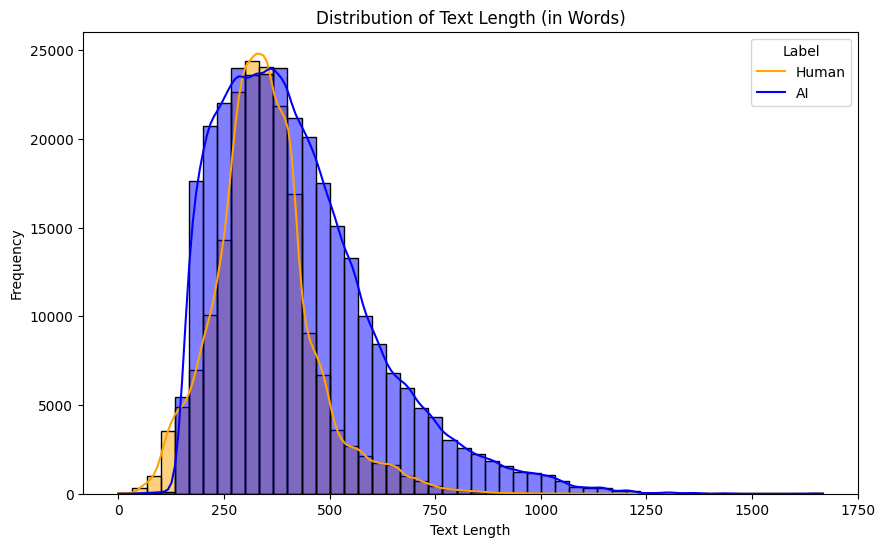

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='generated', bins=50, kde=True, palette={0: 'blue', 1: 'orange'}, fill=True)
plt.title('Distribution of Text Length (in Words)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Human', 'AI'])
plt.show()

As we can see, the text length distribution is different for human and AI generated texts. Human generated texts tend to be shorter, while AI generated texts tend to be longer. This could be due to the fact that human generated texts are more concise and to the point, while AI generated texts are more verbose and detailed.

Let's see the text richness in ai generated text and human ai generated text

In [11]:

def type_token_ratio(text):
    tokens = text.lower().split()
    return len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0

df['ttr'] = df['text'].apply(type_token_ratio)

# Compare between classes
df.groupby('generated')['ttr'].describe()

,count,mean,std,min,25%,50%,75%,max
generated,,,,,,,,
0.0,305797.0,0.480593,0.083189,0.053957,0.424040,0.48105,0.537931,0.928571
1.0,181438.0,0.510901,0.093479,0.000000,0.444915,0.50000,0.569475,1.000000



- **AI Text (mean = 0.51)** is **slightly more lexically rich** than human text (mean = 0.48), suggesting more varied vocabulary.
- However, **overlapping ranges** indicate both can have diverse or repetitive language.

In [12]:
def count_punctuation(text):
    return sum(1 for char in text if char in string.punctuation)

df['punctuation_count'] = df['text'].apply(count_punctuation)

df.groupby('generated')['punctuation_count'].describe()

,count,mean,std,min,25%,50%,75%,max
generated,,,,,,,,
0.0,305797.0,48.996066,27.241608,0.0,30.0,44.0,62.0,388.0
1.0,181438.0,46.552089,22.428644,0.0,31.0,42.0,58.0,258.0



- **Human Text (mean = 49)** uses **slightly more punctuation** than AI text (mean = 46.5).
- The distribution shows **similar variability**, but some human texts are far more punctuated (max = 388 vs. 258).


In [13]:
stop_words = set(stopwords.words('english'))

def stopword_ratio(text):
    tokens = text.lower().split()
    if len(tokens) == 0:
        return 0
    stop_count = sum(1 for token in tokens if token in stop_words)
    return stop_count / len(tokens)

df['stopword_ratio'] = df['text'].apply(stopword_ratio)

df.groupby('generated')['stopword_ratio'].describe()


,count,mean,std,min,25%,50%,75%,max
generated,,,,,,,,
0.0,305797.0,0.477323,0.052504,0.201373,0.444444,0.480000,0.512748,0.724696
1.0,181438.0,0.431636,0.061010,0.000000,0.393548,0.435821,0.474023,0.653846


- **Human Text (mean = 0.48)** has a **higher stopword ratio** than AI text (mean = 0.43).
- This suggests humans use **more natural filler words** like "the", "and", "is", which AI may underuse.


## 3. Text Preprocessing

Filter out and remove normalize text

In [14]:
df['text'] = df['text'].str.lower() # lower text
df['text'] = df['text'].str.strip().str.replace(r'\s+', ' ', regex=True) # strip the text
df['text'] = df['text'].str.translate(str.maketrans('', '', string.punctuation)) # remove puncituation

Remove Stopwords

In [15]:
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

Remove noise like (emails, urls)

In [16]:
def remove_noise(text):
    text = re.sub(r'http\S+|www\.\S+', '', text)      # URLs
    text = re.sub(r'\S+@\S+\.\S+', '', text)          # Emails
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)        # Hashtags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)        # Mentions
    text = re.sub(r'\d+', '', text)                   # Numbers
    return ''.join(ch for ch in text if ch.isprintable())  # Non-printable
df['text'] = df['text'].apply(remove_noise)

Remove very short or very long text

Plot before removing

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


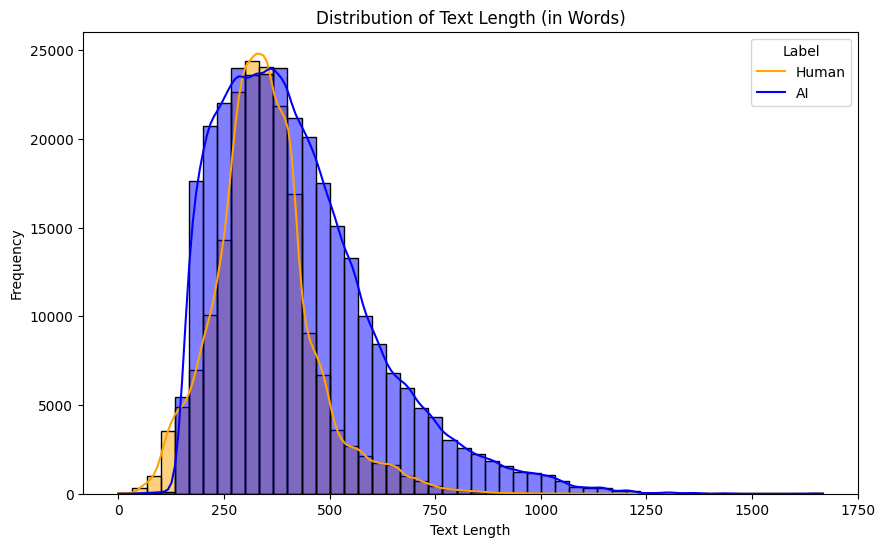

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='generated', bins=50, kde=True, palette={0: 'blue', 1: 'orange'}, fill=True)
plt.title('Distribution of Text Length (in Words)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Human', 'AI'])
plt.show()

we will ensure that there is no very long texts and no very short texts to make it easier for us to train the model.

In [18]:
human_min_words, human_max_words = df[df['generated'] == 0 ]['text_length'].quantile([.01, .99])
ai_min_words, ai_max_words = df[df['generated'] == 1 ]['text_length'].quantile([.01, .99])

print(human_min_words, human_max_words)
print(ai_min_words, ai_max_words)

160.0 1007.0
106.0 705.0


In [19]:
# Create masks for each class
human_mask = (df['generated'] == 0) & df['text_length'].between(human_min_words, human_max_words)
ai_mask    = (df['generated'] == 1) & df['text_length'].between(ai_min_words, ai_max_words)

# Combine masks to filter the DataFrame
df_filtered = df[human_mask | ai_mask].copy()

# Optional: reset index
df_filtered.reset_index(drop=True, inplace=True)

# Show resulting shapes and sample
print("Original dataset shape:", df.shape)
print("Filtered dataset shape:", df_filtered.shape)

df_filtered.head()
df = df.drop_duplicates(subset='text')

Original dataset shape: (487235, 6)
Filtered dataset shape: (477953, 6)


In [20]:
df_filtered.describe()

,generated,text_length,ttr,punctuation_count,stopword_ratio
count,477953.000000,477953.000000,477953.000000,477953.000000,477953.000000
mean,0.372210,389.670779,0.491375,47.698081,0.460188
std,0.483395,156.409502,0.086700,24.235193,0.059791
min,0.000000,106.000000,0.093023,0.000000,0.070632
25%,0.000000,279.000000,0.432373,30.000000,0.423656
50%,0.000000,362.000000,0.487179,43.000000,0.464986
75%,1.000000,468.000000,0.547401,60.000000,0.501312
max,1.000000,1007.000000,0.902985,290.000000,0.724696


In [21]:
df = df_filtered

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


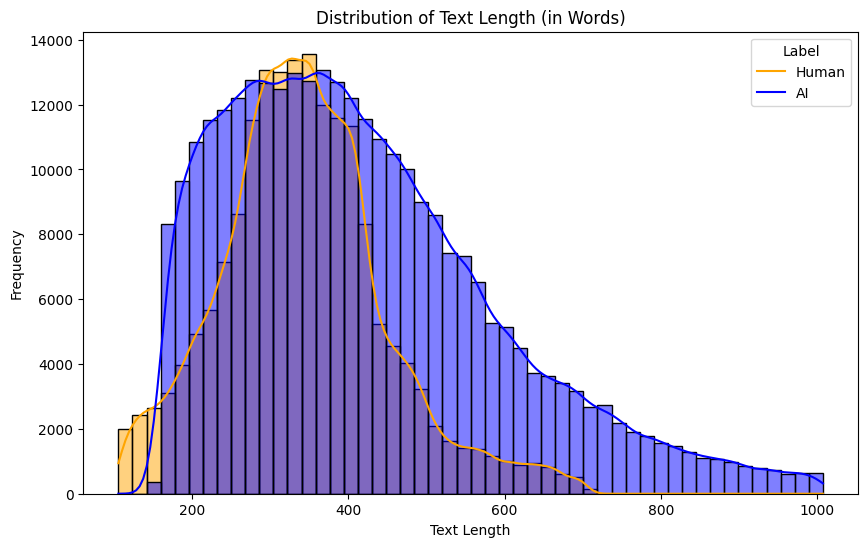

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='generated', bins=50, kde=True, palette={0: 'blue', 1: 'orange'}, fill=True)
plt.title('Distribution of Text Length (in Words)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Human', 'AI'])
plt.show()

## 4. Model Selection

Split data into X and y.

In [23]:
X, y = df['text'], df['generated']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

We will use the next pipeline to:

- Convert text into word counts (CountVectorizer),

- Weight the counts by importance across documents (TfidfTransformer),

- Classify the processed features using a simple and fast model (MultinomialNB).

In [25]:
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer()), 
    ('tfidf_transformer', TfidfTransformer()),
    ('naive_bayes', MultinomialNB())])

In [26]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', TfidfTransformer()),
                ('naive_bayes', MultinomialNB())])

Initial Model Results before hyperparameter fine-tuning

In [27]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     74879
         1.0       0.98      0.90      0.94     44610

    accuracy                           0.95    119489
   macro avg       0.96      0.94      0.95    119489
weighted avg       0.96      0.95      0.95    119489



## 5. Hyperparameter Fine-tuning

In [28]:
def objective(trial):
    ngram_range = trial.suggest_categorical('ngram_range', [(1,1), (1,2), (1,3)])
    use_idf = trial.suggest_categorical('use_idf', [True, False])
    alpha = trial.suggest_float('alpha', 1e-3, 1.0, log=True)

    pipeline = Pipeline([
        ('count_vectorizer', CountVectorizer(ngram_range=ngram_range)),
        ('tfidf_transformer', TfidfTransformer(use_idf=use_idf)),
        ('naive_bayes', MultinomialNB(alpha=alpha))
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, preds)

    print(f"Trial {trial.number}: Accuracy={accuracy:.4f}, ngram_range={ngram_range}, use_idf={use_idf}, alpha={alpha:.4f}")

    return accuracy


In [29]:
def early_stop_callback(study, trial):
    if trial.value and trial.value > 0.99:
        print("High accuracy reached. Stopping study...")
        study.stop()


In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, callbacks=[early_stop_callback])


[I 2025-04-19 15:43:10,333] A new study created in memory with name: no-name-c7645528-9d94-4be6-a402-5c4484c41e3c
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.
  warnings.warn(message)
[I 2025-04-19 15:48:34,111] Trial 0 finished with value: 0.9980500297098478 and parameters:

Trial 0: Accuracy=0.9981, ngram_range=(1, 2), use_idf=True, alpha=0.0025
High accuracy reached. Stopping study...


In [31]:
print("Best trial:", study.best_trial.value)
print("Best params:", study.best_trial.params)


Best trial: 0.9980500297098478
Best params: {'ngram_range': (1, 2), 'use_idf': True, 'alpha': 0.0024583934185221337}


In [32]:
best_params = study.best_trial.params

best_pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(ngram_range=best_params['ngram_range'])),
    ('tfidf_transformer', TfidfTransformer(use_idf=best_params['use_idf'])),
    ('naive_bayes', MultinomialNB(alpha=best_params['alpha']))
])

In [33]:
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     74879
         1.0       1.00      1.00      1.00     44610

    accuracy                           1.00    119489
   macro avg       1.00      1.00      1.00    119489
weighted avg       1.00      1.00      1.00    119489



Save the model

In [34]:
import joblib
joblib.dump(best_pipeline, 'best_model.joblib')

print("done!!")


done!!
